In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using MDToolbox
ENV["COLUMNS"] = 130

130

In [2]:
#include("./tram.jl")

In [3]:
"""
    tram(c_ijk, N_ik, b_kln, index_of_cluster_kn; tol=1e-10, max_iter=20)

Estimates the free energy differences by transition-based reweighting analysis method (TRAM).

## Arguments
- `c_ijk::AbstractArray`: Array containing the counts of transitions from state `i` to state `j` in ensemble `k`.
- `N_ik::AbstractArray`: Array containing the counts of samples in state `i` in ensemble `k`.
- `N_k::AbstractArray`: Array containing the counts of samples in ensemble `k`.
- `b_kln::AbstractArray`: Array of bias factors of state `k` evaluated at state `l`.
- `index_of_cluster_kn::AbstractArray`: Array fo index of the state to which the nth sample of ensemble `k` belongs.. 

## Optional Arguments
- `tol::Real = 1e-10`: Tolerance value for convergence criteria.
- `max_iter::Integer = 20`: Maximum number of iterations allowed.
"""
function tram(c_ijk, N_ik, N_k, b_kln, index_of_cluster_kn; tol=1e-10, max_iter=100)
    f_ik, v_ik, R_ik = tram_init(c_ijk, N_ik)

    for i in 1:max_iter
        for j in 1:100 #この100はなんとなくの値, f_ikの更新に比べ計算量が少ないため適当に大きい値を設定している
            v_new_ik = tram_v_new_ik(c_ijk, v_ik, f_ik)
            #=
            if(j == 100)
                println("delta = $(maximum(abs.(v_ik .- v_new_ik)))")
                v_ik = v_new_ik
            end
            =#
            v_ik = v_new_ik
        end
        
        R_ik = tram_R_ik(c_ijk, v_ik, f_ik, N_ik)
        f_new_ik = tram_f_new_ik(f_ik, R_ik, b_kln, N_k, index_of_cluster_kn)
        max_dif = maximum(abs.(f_ik .- f_new_ik))
        if i % (max_iter/10) == 1 || i == max_iter 
            println("iteration = $(i), delta = $(max_dif)")
        end
        f_ik = f_new_ik
        if(max_dif < tol)
            println("iteration = $(i), delta = $(max_dif)")
            break
        end
    end
    
    return f_ik, v_ik, R_ik
end

function tram_by_delta(c_ijk, N_ik, N_k, b_kln, index_of_cluster_kn; tol=1e-10, max_iter=10000)
    f_ik, v_ik, R_ik = tram_init(c_ijk, N_ik)

    for i in 1:max_iter
        for j in 1:100 #この100はなんとなくの値, f_ikの更新に比べ計算量が少ないため適当に大きい値を設定している
            v_new_ik = tram_v_new_ik(c_ijk, v_ik, f_ik)
            #=
            if(j == 100)
                println("delta = $(maximum(abs.(v_ik .- v_new_ik)))")
                v_ik = v_new_ik
            end
            =#
            v_ik = v_new_ik
        end
        
        R_ik = tram_R_ik(c_ijk, v_ik, f_ik, N_ik)
        #f_new_ik = tram_f_new_ik(f_ik, R_ik, b_kln, N_k, index_of_cluster_kn)
        f_new_ik = similar(f_ik)
        δ_i = tram_δ_i(c_ijk, v_ik, f_ik)
        for j in 1:m
            f_new_ik[j, :] = f_ik[j, :] .+ δ_i[j]
        end
        
        max_dif = maximum(abs.(f_ik .- f_new_ik))
        if i % (max_iter/10) == 1 || i == max_iter 
            println("iteration = $(i), delta = $(max_dif)")
        end
        f_ik = f_new_ik
        if(max_dif < tol)
            println("iteration = $(i), delta = $(max_dif)")
            break
        end
    end
    
    return f_ik, v_ik, R_ik
end

function tram_δ_i(c_ijk, v_ik, f_ik)
    m, K = size(v_ik)

    δ_i = zeros(Float64, m)
    for i in 1:m
        x = 0
        for k in 1:K
            for j in 1:m
                x += (c_ijk[i, j, k] + c_ijk[j, i, k]) * v_ik[j, k] / (v_ik[j, k] + exp(f_ik[i, k] - f_ik[j, k]) * v_ik[i, k])
            end
        end
        δ_i[i] = log(x) - log(sum(c_ijk[:, i, :]))
    end

    return δ_i
end

function tram_p_ijk(c_ijk, v_ik, f_ik)
    m, K = size(f_ik)

    p_ijk = zeros(Float64, m, m, K)
    for k in 1:K
        for i in 1:m
            for j in 1:m
                p_ijk[i, j, k] = (c_ijk[i, j, k] + c_ijk[j, i, k]) / (exp(f_ik[j, k] - f_ik[i, k]) * v_ik[j, k] + v_ik[i, k])
            end
        end
    end
    return p_ijk
end

function tram_R_ik(c_ijk, v_ik, f_ik, N_ik)
    m, K = size(N_ik)

    R_ik = zeros(Float64, m, K)
    for k in 1:K
        for i in 1:m   
            for j in 1:m
                R_ik[i, k] += (c_ijk[i, j, k] + c_ijk[j, i, k]) * v_ik[j, k] / (v_ik[j, k] + exp(f_ik[i, k] - f_ik[j, k]) * v_ik[i, k])
            end
            R_ik[i, k] += N_ik[i, k]
            for j in 1:m
                R_ik[i, k] -= c_ijk[j, i, k]
            end
        end
    end

    return R_ik
end

function tram_v_new_ik(c_ijk, v_ik, f_ik)
    m, K = size(f_ik)

    v_new_ik = zeros(Float64, m, K)
    for k in 1:K
        for i in 1:m
            for j in 1:m
                v_new_ik[i, k] += v_ik[i, k] * (c_ijk[i, j, k] + c_ijk[j, i, k]) / (exp(f_ik[j, k] - f_ik[i, k]) * v_ik[j, k] + v_ik[i, k])
            end
        end
    end
    return v_new_ik
end

# f^k,newの計算では、Σ_(x∈X_i)があるため、index_of_cluster_knを用いる
# b_klnはkアンサンブルをl番目のポテンシャルで評価したもの
function tram_f_new_ik(f_ik, R_ik, b_kln, N_k, index_of_cluster_kn)
    m, K = size(f_ik)
    f_new_ik = zeros(Float64, m, K)

    for k in 1:K
        for i in 1:m
            log_wik_jn = tram_log_wik_jn(f_ik, R_ik, b_kln, N_k, i, k)
            log_wik = log_wik_jn[index_of_cluster_kn .== i]
            f_new_ik[i, k] = - MDToolbox.logsumexp(log_wik)
        end
    end

    f_new_ik = normalize_f_ik(f_new_ik)
    return f_new_ik
end

# K×N_maxの配列で、f_ikの更新に用いる
# j行目n列目はjアンサンブルのn個目のデータを用い更新する
function tram_log_wik_jn(f_ik, R_ik, b_kln, N_k, istate, kstate)
    m, K = size(f_ik)
    log_wik_jn = zeros(Float64, (K, maximum(N_k)))

    for k in 1:K
        x = repeat(log.(R_ik[istate, :]), 1, N_k[k]) .+ repeat(f_ik[istate, :], 1, N_k[k]) .- (b_kln[k, :, 1:N_k[k]] .- repeat(b_kln[k:k, kstate, 1:N_k[k]], K, 1))
        log_wik_jn[k:k, 1:N_k[k]] .= - logsumexp_over_row(x)
    end
    return log_wik_jn
end

# k=1に対してΣ_i(exp(-f_ik))=1
function normalize_f_ik(f_ik)
    m, K = size(f_ik)
    normalized_f_ik = similar(f_ik)
    s = MDToolbox.logsumexp(-f_ik[:, 1])
    normalized_f_ik = f_ik .+ s
    return normalized_f_ik
end

# この関数は未完成
# 実際はlog_μ_xの計算で、x_gridをb_kで評価しなければならない
function tram_μ(f_ik, R_ik, b_k::Function, N_ik, index_of_cluster_kn, center_of_cluster, x_grid)
    m, K = size(f_ik)

    log_μ_x = zeros(Float64, length(x_grid))
    μ_x = zeros(Float64, length(x_grid))
    for x in x_grid
        ix = argmin((center_of_cluster .- x) .^ 2)[1]
        for k in 1:K
            log_μ_x = - MDToolbox.logsumexp(log(R_ik[ix, k]) + f_ik[ix, k] - b_k[k](x))
        end
    end

    μ_x = exp.(log_μ_x)
    return μ_x
end

function tram_init(c_ijk, N_ik)
    m, K = size(N_ik)
    f_ik = ones(Float64, m, K)
    f_ik = normalize_f_ik(f_ik)

    v_ik = ones(Float64, m, K)

    R_ik = tram_R_ik(c_ijk, v_ik, f_ik, N_ik)

    return f_ik, v_ik, R_ik
end

function logsumexp_over_row(x)
    max_x = maximum(x, dims=1)
    exp_x = exp.(x .- max_x)
    s = log.(sum(exp_x, dims=1)) .+ max_x
    return s
end

logsumexp_over_row (generic function with 1 method)

In [4]:
?tram

search: tram tram_μ tram_δ_i tram_init tram_R_ik tram_p_ijk tram_v_new_ik



```
tram(c_ijk, N_ik, b_kln, index_of_cluster_kn; tol=1e-10, max_iter=20)
```

Estimates the free energy differences by transition-based reweighting analysis method (TRAM).

## Arguments

  * `c_ijk::AbstractArray`: Array containing the counts of transitions from state `i` to state `j` in ensemble `k`.
  * `N_ik::AbstractArray`: Array containing the counts of samples in state `i` in ensemble `k`.
  * `N_k::AbstractArray`: Array containing the counts of samples in ensemble `k`.
  * `b_kln::AbstractArray`: Array of bias factors of state `k` evaluated at state `l`.
  * `index_of_cluster_kn::AbstractArray`: Array fo index of the state to which the nth sample of ensemble `k` belongs..

## Optional Arguments

  * `tol::Real = 1e-10`: Tolerance value for convergence criteria.
  * `max_iter::Integer = 20`: Maximum number of iterations allowed.


In [5]:
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

compute_energy (generic function with 1 method)

In [6]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [7]:
function _compute_distance(coords1, coords2)
    r = sqrt(sum((coords1 .- coords2).^2))
    return r
end

_compute_distance (generic function with 1 method)

## MCMC

In [8]:
#次のステップ候補点
function next_coords(coords1, coords2, delta_x = 1e-2)
    next_coords1 = coords1 .+ (rand(3) .- 0.5) .* delta_x
    next_coords2 = coords2 .+ (rand(3) .- 0.5) .* delta_x
    return next_coords1, next_coords2
end

#MCMC,メトロポリス法
function mcmc(coords1, coords2, epsilon, sigma, nstep = 100, beta = 1.0)
    coords1_trj = []
    coords2_trj = []
    alpha_trj = []
    push!(coords1_trj, coords1)
    push!(coords2_trj, coords2)
    
    for i in 1:nstep
        next_coords1, next_coords2 = next_coords(coords1, coords2) #候補点
        delta_U = compute_energy(next_coords1, next_coords2, epsilon, sigma) - compute_energy(coords1, coords2, epsilon, sigma)
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha >= rand()
            coords1 .= next_coords1
            coords2 .= next_coords2
        end     
        push!(coords1_trj, copy(coords1))
        push!(coords2_trj, copy(coords2))
        push!(alpha_trj, alpha)
    end
    
    coords1_trj = transform_matrix(hcat(coords1_trj...))
    coords2_trj = transform_matrix(hcat(coords2_trj...))
    
    return coords1_trj, coords2_trj, alpha_trj
end

function transform_matrix(matrix)
    rows, cols = size(matrix)
    transformed_matrix = [matrix[j, i] for i in 1:cols, j in 1:rows]
    return transformed_matrix
end

transform_matrix (generic function with 1 method)

In [9]:
K = 3

epsilon = Vector{Float64}(undef, K)
sigma = Vector{Float64}(undef, K)

epsilon[1] = 1.0
sigma[1] = 2.0

epsilon[2] = 1.01
sigma[2] = 2.01

epsilon[3] = 1.02
sigma[3] = 2.02

kBT = 2.0
beta = 1.0/(kBT)
nstep = 1000000

#seed_value = 123 #乱数固定
#Random.seed!(seed_value)

trj1_k = Vector{Any}(undef, K)
trj2_k = Vector{Any}(undef, K)
for k = 1:K
    coords = ([0.0, 0.0, 0.0], [sigma[k], 0.0, 0.0]) #初期座標
    trj1_k[k], trj2_k[k], alpha = mcmc(coords[1], coords[2], epsilon[k], sigma[k], nstep, beta)
end

In [10]:
u_kl = Array{Array{Float64}}(undef, (K, K))
for k in 1:K
    for l in 1:K
        u_kl[k, l] = map(i -> beta * compute_energy(trj1_k[k][i, :], trj2_k[k][i, :], epsilon[l], sigma[l]), 1:nstep)
    end
end

distance_k = Vector{Vector{Float64}}(undef, K)
for k in 1:K
    distance_k[k] = zeros(Float64, nstep)
    for i in 1:nstep
        distance_k[k][i] = _compute_distance(trj1_k[k][i, :], trj2_k[k][i, :])
    end
end

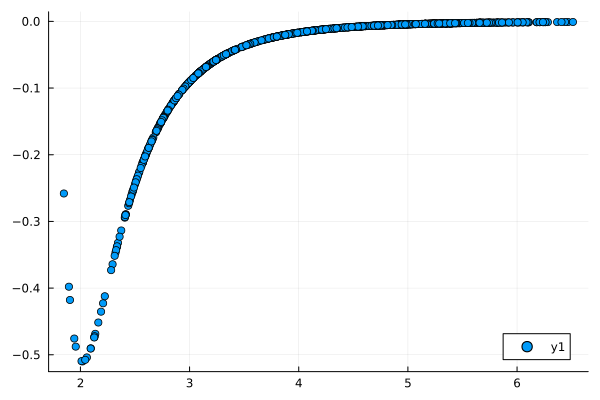

In [11]:
kstate = 3

scatter(distance_k[kstate][1:1000:end], u_kl[kstate, kstate][1:1000:end])

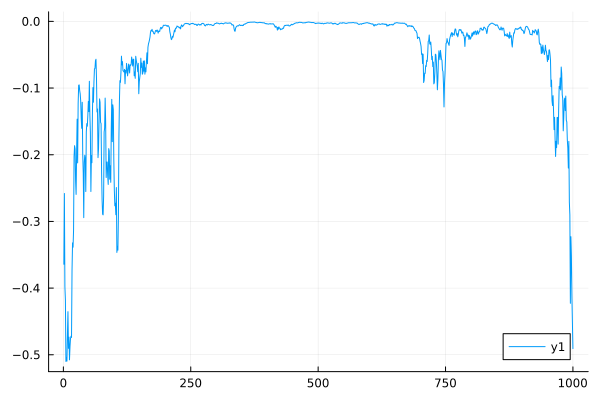

In [12]:
plot(u_kl[kstate, kstate][1:1000:end])

## MSM

In [13]:
ncluster = 1
tau = 10

K = 3
m = ncluster

c_ijk = zeros(Int64, m, m, K)
N_ik = zeros(Int64, m, K)

X = vcat(distance_k...)
X = reshape(X, length(X), 1)
#F = clusterkcenters(X ,ncluster)
F = clusterkmeans(X, m)

index_of_cluster_kn = zeros(Int64, K, length(distance_k[1]))
center_of_cluster = F.center

istart = 1
for k in 1:length(distance_k)
    iend = istart + length(distance_k[k]) - 1
    c_ijk[:, :, k] = msmcountmatrix(F.indexOfCluster[istart:iend], tau=tau)
    for i in 1:ncluster
        N_ik[i, k] = count(x -> x == i, F.indexOfCluster[istart:iend])
    end
    index_of_cluster_kn[k, :] = F.indexOfCluster[istart:iend]
    istart = iend + 1
end

In [14]:
N_k = Array{Int}(undef, K)
for k in 1:K
    N_k[k] = length(distance_k[k])
end
u_kln = zeros(Float64, K, K, maximum(N_k))
for k in 1:K
    for l in 1:K
        u_kln[k, l, 1:N_k[k]] .= u_kl[k, l]
    end
end

In [15]:
@time f_ik, v_ik, R_ik = tram(c_ijk, N_ik, N_k, u_kln, index_of_cluster_kn, tol=1e-10, max_iter=100)

iteration = 1, delta = 0.0005913045607819356
iteration = 3, delta = 1.0315304166397254e-11
  5.521525 seconds (1.61 M allocations: 5.136 GiB, 17.41% gc time, 24.06% compilation time)


([0.0 -0.0002783318750481101 -0.0005913825719598975], [999990.0 999990.0 999990.0], [1.0e6 1.0e6 1.0e6])

In [16]:
mbar_f_k = mbar(u_kl)

iteration = 1  delta = 1.998851e+00  tol = 1.000000e-08
free energies =  0.000000 -0.000278 -0.000591

iteration = 2  delta = 2.636402e-04  tol = 1.000000e-08
free energies =  0.000000 -0.000278 -0.000591

iteration = 3  delta = 3.486536e-08  tol = 1.000000e-08
free energies =  0.000000 -0.000278 -0.000591

iteration = 4  delta = 0.000000e+00  tol = 1.000000e-08
free energies =  0.000000 -0.000278 -0.000591

iteration = 5  delta = 0.000000e+00  tol = 1.000000e-08
free energies =  0.000000 -0.000278 -0.000591

iteration = 6  delta = 0.000000e+00  tol = 1.000000e-08
free energies =  0.000000 -0.000278 -0.000591

iteration = 7  delta = 0.000000e+00  tol = 1.000000e-08
free energies =  0.000000 -0.000278 -0.000591

iteration = 8  delta = 0.000000e+00  tol = 1.000000e-08
free energies =  0.000000 -0.000278 -0.000591

iteration = 9  delta = 0.000000e+00  tol = 1.000000e-08
free energies =  0.000000 -0.000278 -0.000591

iteration = 10  delta = 0.000000e+00  tol = 1.000000e-08
free energies = 

3-element Vector{Float64}:
  0.0
 -0.0002783318750482731
 -0.0005913825719600838

In [17]:
p_ijk = tram_p_ijk(c_ijk, v_ik, f_ik)

1×1×3 Array{Float64, 3}:
[:, :, 1] =
 1.0

[:, :, 2] =
 1.0

[:, :, 3] =
 1.0

In [18]:
# m=1以外の場合でも全部ゼロになるためpの計算式はあってそう
for k in 1:K
    for i in 1:m
        for j in 1:m
            println(exp(-f_ik[i, k]) * p_ijk[i, j, k] - exp(-f_ik[j, k]) * p_ijk[j, i, k])
        end
    end
end

0.0
0.0
0.0


In [19]:
# tram
for k in 1:K
    for i in 1:m
        a = 0
        for j in 1:K
            for n in 1:N_k[j]
                if(index_of_cluster_kn[j, n] == i)
                    bunsi = 0
                    bunbo = 0
                    bunsi = exp(f_ik[i, k] - u_kln[j, k, n])
                    #=
                    for l in 1:K
                        bunbo += R_ik[1, l] * exp(f_ik[1, l] - u_kln[l, j, n])
                    end
                    =#
                    logbunbo = MDToolbox.logsumexp(log.(R_ik[i, :]) + f_ik[i, :] -u_kln[j, :, n])
                    bunbo = exp(logbunbo)
                    a += bunsi / bunbo
                end
            end
        end
        println("kstate = $(k) istate = $(i) dif = $(a)")
    end
end

kstate = 1 istate = 1 dif = 0.999999999999983
kstate = 2 istate = 1 dif = 0.9999999999999544
kstate = 3 istate = 1 dif = 1.0000000000000941


In [20]:
# mbar
for k in 1:K   
    a = 0
    for j in 1:K
        for n in 1:N_k[j]
            bunsi = 0
            bunbo = 0
            bunsi = exp(mbar_f_k[k] - u_kln[j, k, n])
            #=
            for l in 1:K
                bunbo += N_k[l] * exp(mbar_f_k[l] - u_kln[j, l, n])
            end
            =#
            logbunbo = MDToolbox.logsumexp(log.(N_k[:]) + mbar_f_k[:] - u_kln[j, :, n])
            bunbo = exp(logbunbo)
            a += bunsi / bunbo
        end
    end
    println("kstate = $(k) a = $(a)")
end

kstate = 1 a = 0.999999999999983
kstate = 2 a = 0.9999999999999541
kstate = 3 a = 1.000000000000094


In [21]:
# tram
f_ik

1×3 Matrix{Float64}:
 0.0  -0.000278332  -0.000591383

In [22]:
# mbar
mbar_f_k

3-element Vector{Float64}:
  0.0
 -0.0002783318750482731
 -0.0005913825719600838